##### user_id:用户ID，order_dt:购买日期，order_products:购买产品数量,order_amount:购买金额

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
plt.style.use('ggplot')  #更改绘图风格，R语言绘图库的风格
plt.rcParams['font.sans-serif'] = ['Hiragino Sans GB']

In [3]:
#导入数据
columns = ['user_id','order_dt','order_products','order_amount']
df = pd.read_table('CDNOW_master.txt',names=columns,sep='\s+')  #sep:'\s+':匹配任意个空格
df.head()
#1.日期格式需要转换
#2.存在同一个用户一天内购买多次行为

,user_id,order_dt,order_products,order_amount
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


In [4]:
df.describe()
#1.用户平均每笔订单购买2.4个商品，标准差2.3，稍微有点波动，属于正常。
#然而75%分位数的时候，说明绝大多数订单的购买量都不多，围绕在2~3个产品左右；
#2.购买金额，反映出大部分订单消费金额集中在中小额，30~45左右

,user_id,order_dt,order_products,order_amount
count,69659.000000,6.965900e+04,69659.000000,69659.000000
mean,11470.854592,1.997228e+07,2.410040,35.893648
std,6819.904848,3.837735e+03,2.333924,36.281942
min,1.000000,1.997010e+07,1.000000,0.000000
25%,5506.000000,1.997022e+07,1.000000,14.490000
50%,11410.000000,1.997042e+07,2.000000,25.980000
75%,17273.000000,1.997111e+07,3.000000,43.700000
max,23570.000000,1.998063e+07,99.000000,1286.010000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         69659 non-null  int64  
 1   order_dt        69659 non-null  int64  
 2   order_products  69659 non-null  int64  
 3   order_amount    69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


### 数据预处理

In [6]:
df['order_date']=pd.to_datetime(df['order_dt'],format='%Y%m%d')
#format参数：按照指定的格式去匹配要转换的数据列。
#%Y:四位的年份1994   %m:两位月份05  %d:两位月份31  
#%y：两位年份94  %h:两位小时09  %M：两位分钟15    %s:两位秒 
#将order_date转化成精度为月份的数据列
df['month']=df['order_date'].astype('datetime64[M]') #[M] :控制转换后的精度 month
df.head()

,user_id,order_dt,order_products,order_amount,order_date,month
0,1,19970101,1,11.77,1997-01-01,1997-01-01
1,2,19970112,1,12.00,1997-01-12,1997-01-01
2,2,19970112,5,77.00,1997-01-12,1997-01-01
3,3,19970102,2,20.76,1997-01-02,1997-01-01
4,3,19970330,2,20.76,1997-03-30,1997-03-01


Text(0.5, 1.0, '每月的消费人数')

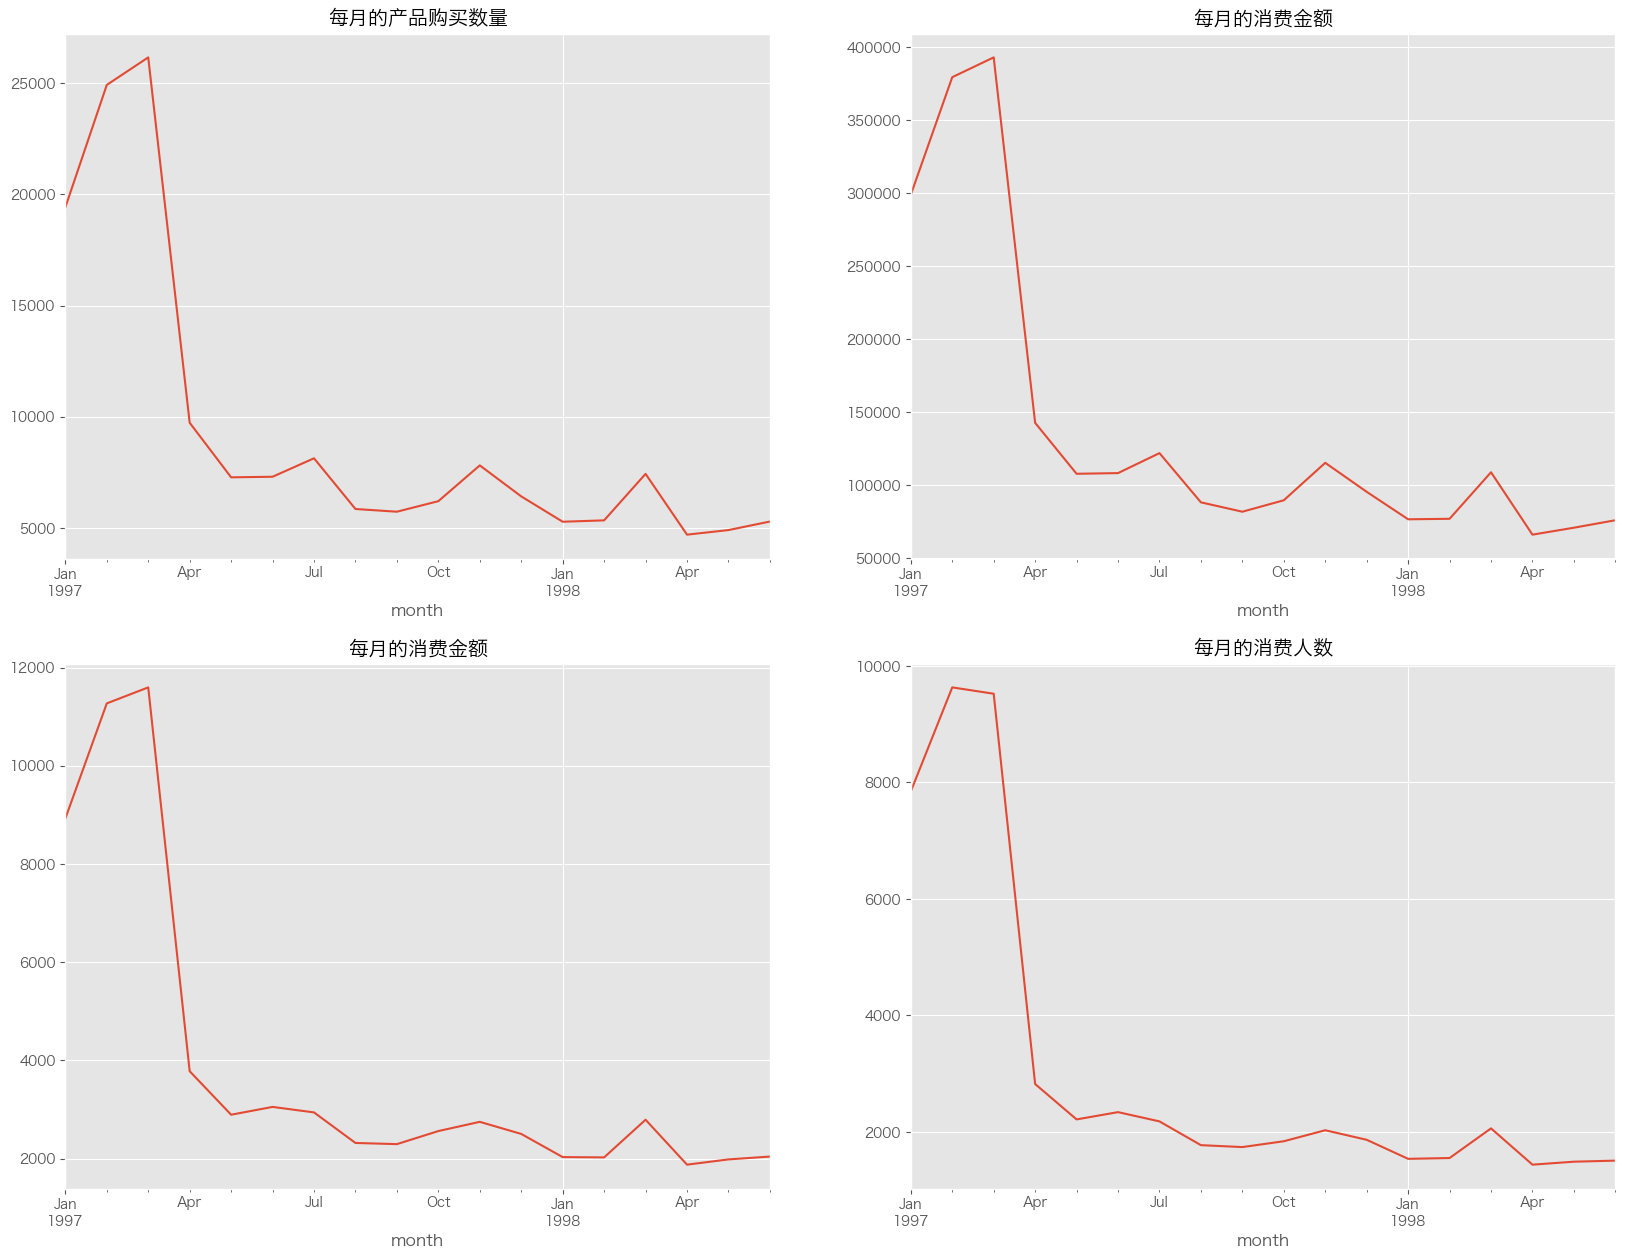

In [7]:
# 用户整体消费趋势分析（按月份）
# 按月份统计产品购买数量，消费金额，消费次数，消费人数
plt.figure(figsize=(20,15))#单位是英寸
# 每月的产品购买数量
plt.subplot(221) #两行两列，占据第一个位置
df.groupby(by='month')['order_products'].sum().plot()#默认折线图
plt.title('每月的产品购买数量')
# 每月的消费金额
plt.subplot(222)  #两行两列
df.groupby(by='month')['order_amount'].sum().plot()  #默认折线图
plt.title('每月的消费金额')
# 每月的消费次数
plt.subplot(223)  #两行两列
df.groupby(by='month')['user_id'].count().plot()  #默认折线图
plt.title('每月的消费金额')
# 每月的消费人数（根据user_id进行去重统计，再计算个数）
plt.subplot(224)  #两行两列
df.groupby(by='month')['user_id'].apply(lambda x:len(x.drop_duplicates())).plot()  #用count也可以.apply(lambda x: x.drop_duplicates().count()).plot()

plt.title('每月的消费人数')
#分析结果：
# 图一可以看出，前三个月销量非常高，而以后销量较为稳定，并且稍微呈现下降趋势
# 图二可以看出,依然前三个月消费金额较高，与消费数量成正比例关系，三月份过后下降严重，并呈现下降趋势，思考原因？1：跟月份有关，
# 在我国来1，2，3月份处于春节前后。2.公司在1，2，3，月份的时候是否加大了促销力度
# 图三可以看出，前三个月订单数在10000左右，后续月份的平均消费单数在2500左右
# 图四可以看出，前三个月消费人数在8000~10000左右，后续平均消费消费在2000不到的样子
# 总结：所有数据显示，97年前三月消费事态异常，后续趋于常态化

## 用户个体消费分析

### 1.用户消费金额，消费次数(产品数量)描述统计

In [8]:
user_grouped=df.groupby(by='user_id').sum()
print(user_grouped.describe())
print('用户数量:',len(user_grouped))
# 从用户的角度：用户数量23570个，每个用户平均购买7个CD，但是中位数只有3，
#  并且最大购买量为1033，平均值大于中位数，属于典型的右偏分布(替购买量<7的用户背锅)
# 从消费金额角度：平均用户消费106，中位数43，并且存在土豪用户13990，结合分位数和最大值来看，平均数与75%分位数几乎相等，
# 属于典型的右偏分布，说明存在小部分用户（后面的25%）高额消费（这些用户需要给消费金额<106的用户背锅，只有这样才能使平均数维持在106）

           order_dt  order_products  order_amount
count  2.357000e+04    23570.000000  23570.000000
mean   5.902627e+07        7.122656    106.080426
std    9.460684e+07       16.983531    240.925195
min    1.997010e+07        1.000000      0.000000
25%    1.997021e+07        1.000000     19.970000
50%    1.997032e+07        3.000000     43.395000
75%    5.992125e+07        7.000000    106.475000
max    4.334408e+09     1033.000000  13990.930000
用户数量: 23570


<AxesSubplot:xlabel='order_products', ylabel='order_amount'>

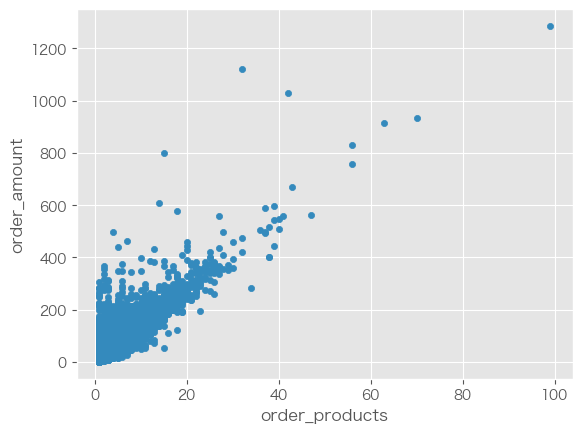

In [9]:
#绘制每个用户的产品的购买量与消费金额散点图
df.plot(kind='scatter',x='order_products',y='order_amount')
# 从图中可知，用户的消费金额与购买量呈现线性趋势，每个商品均价15左右
# 订单的极值点比较少（消费金额>1000，或者购买量大于60）,对于样本来说影响不大，可以忽略不记。

### 2.用户消费分布图

<AxesSubplot:xlabel='每个uid购买的数量', ylabel='Frequency'>

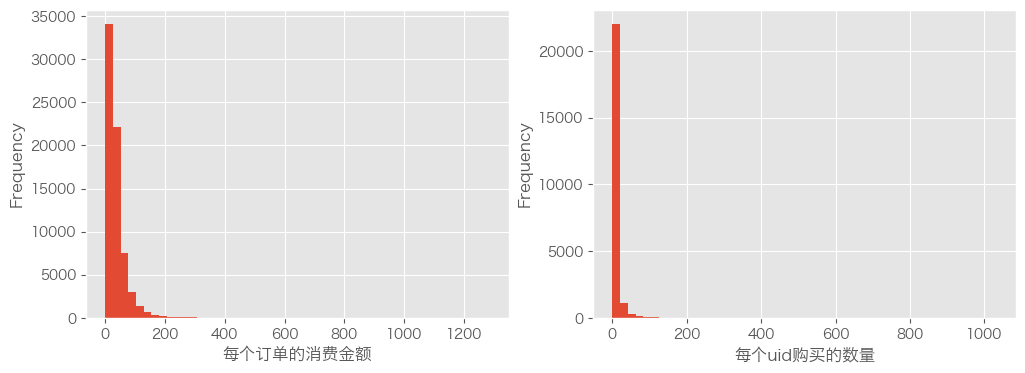

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.xlabel('每个订单的消费金额')
df['order_amount'].plot(kind='hist',bins=50)#bins:区间分数，影响柱子的宽度，值越大柱子越细。宽度=（列最大值-最小值）/bins
#消费金额在100以内的订单占据了绝大多数

plt.subplot(122)
plt.xlabel('每个uid购买的数量')
df.groupby(by='user_id')['order_products'].sum().plot(kind='hist',bins=50)
#图二可知，每个用户购买数量非常小，集中在50以内
# 两幅图得知，我们的用户主要是消费金额低，并且购买小于50的用户人数占据大多数（在电商领域是非常正常的现象）




### 3.用户累计消费金额占比分析（用户的贡献度

In [11]:
#进行用户分组，取出消费金额，进行求和，排序，重置索引
user_cumsum = df.groupby(by='user_id')['order_amount'].sum().sort_values().reset_index()
user_cumsum

,user_id,order_amount
0,10175,0.00
1,4559,0.00
2,1948,0.00
3,925,0.00
4,10798,0.00
...,...,...
23565,7931,6497.18
23566,19339,6552.70
23567,7983,6973.07
23568,14048,8976.33


In [12]:
#每个用户消费金额累加
# 累加器举例：
# a = [1,2,3,4,5,6,7]
# print(np.cumsum(a))
user_cumsum['amount_cumsum'] = user_cumsum['order_amount'].cumsum()
user_cumsum.tail()

,user_id,order_amount,amount_cumsum
23565,7931,6497.18,2463822.60
23566,19339,6552.70,2470375.30
23567,7983,6973.07,2477348.37
23568,14048,8976.33,2486324.70
23569,7592,13990.93,2500315.63


In [13]:
amount_total = user_cumsum['amount_cumsum'].max() #消费金额总值
user_cumsum['prop'] = user_cumsum.apply(lambda x:x['amount_cumsum']/amount_total,axis=1)  #前xx名用户的总贡献率
user_cumsum.tail()

,user_id,order_amount,amount_cumsum,prop
23565,7931,6497.18,2463822.60,0.985405
23566,19339,6552.70,2470375.30,0.988025
23567,7983,6973.07,2477348.37,0.990814
23568,14048,8976.33,2486324.70,0.994404
23569,7592,13990.93,2500315.63,1.000000


<AxesSubplot:>

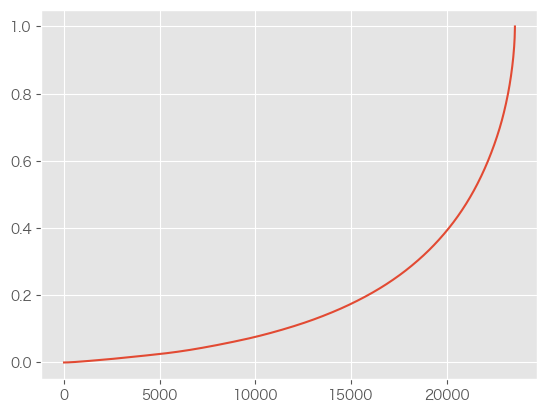

In [14]:
user_cumsum['prop'].plot()
# 由图分析可知，前20000名用户贡献总金额的40%，剩余3500名用户贡献了60%。（2/8原则）

## 用户消费行为

### 1.首购时间

<AxesSubplot:>

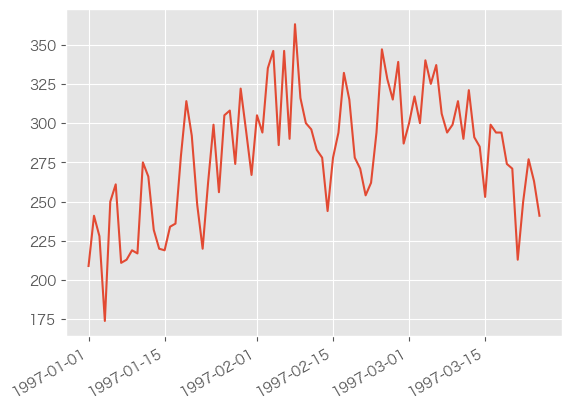

In [15]:
#用户分组，取最小值，即为首购时间，
# A  1997-1-1  
# B  1997-1-1  
# 1997-1-1   ?（2个）
df.groupby(by='user_id')['order_date'].min().value_counts().plot()
# 由图可知，首次购买的用户量在1月1号~2月10号呈明显上升趋势，后续开始逐步下降，猜测：有可能是公司产品的推广力度或者价格调整所致


### 2.最后一次购买时间

<AxesSubplot:>

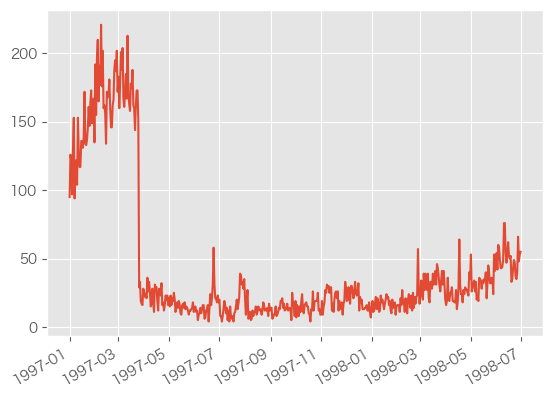

In [16]:
df.groupby(by='user_id')['order_date'].max().value_counts().plot()
# 大多数用户最后一次购买时间集中在前3个月，说明缺少忠诚用户。
#  随着时间的推移，最后一次购买商品的用户量呈现上升趋势，猜测：这份数据选择是的前三个月消费的用户在后面18个月的跟踪记录

## 用户分层


### 1.构建RFM模型

In [17]:
#透视表的使用（index:相当于groupby,values:取出的数据列，aggfunc:key值必须存在于values列中，并且必须跟随有效的聚合函数）
rfm = df.pivot_table(index='user_id',
                    values=['order_products','order_amount','order_date'],
                    aggfunc={
                        'order_date':'max',# 最后一次购买
                        'order_products':'sum',# 购买产品的总数量
                        'order_amount':'sum'  #消费总金额
                        })
rfm.head()

,order_amount,order_date,order_products
user_id,,,
1,11.77,1997-01-01,1
2,89.00,1997-01-12,6
3,156.46,1998-05-28,16
4,100.50,1997-12-12,7
5,385.61,1998-01-03,29


In [18]:
rfm['order_date'].max()

Timestamp('1998-06-30 00:00:00')

In [19]:
# 用每个用户的最后一次购买时间-日期列中的最大值，最后再转换成天数，小数保留一位
rfm['R'] = -(rfm['order_date']-rfm['order_date'].max())/np.timedelta64(1,'D')  #取相差的天数，保留一位小数
rfm.rename(columns={'order_products':'F','order_amount':'M'},inplace=True)
rfm.head()

,M,order_date,F,R
user_id,,,,
1,11.77,1997-01-01,1,545.0
2,89.00,1997-01-12,6,534.0
3,156.46,1998-05-28,16,33.0
4,100.50,1997-12-12,7,200.0
5,385.61,1998-01-03,29,178.0


In [20]:
#RFM计算方式：每一列数据减去数据所在列的平均值，有正有负，根据结果值与1做比较，如果>=1,设置为1，否则0
def rfm_func(x):  #x:分别代表每一列数据
    level = x.apply(lambda x:'1' if x>=1 else '0')
    label = level['R'] + level['F'] + level['M']  #举例：100    001
    d = {
        '111':'重要价值客户',
        '011':'重要保持客户',
        '101':'重要发展客户',
        '001':'重要挽留客户',
        '110':'一般价值客户',
        '010':'一般保持客户',
        '100':'一般发展客户',
        '000':'一般挽留客户'
        
    }
    result = d[label]
    return result
# rfm['R']-rfm['R'].mean()
rfm['label'] = rfm[['R','F','M']].apply(lambda x:x-x.mean()).apply(rfm_func,axis =1)
rfm.head()

,M,order_date,F,R,label
user_id,,,,,
1,11.77,1997-01-01,1,545.0,一般发展客户
2,89.00,1997-01-12,6,534.0,一般发展客户
3,156.46,1998-05-28,16,33.0,重要保持客户
4,100.50,1997-12-12,7,200.0,一般挽留客户
5,385.61,1998-01-03,29,178.0,重要保持客户


Text(0, 0.5, 'R')

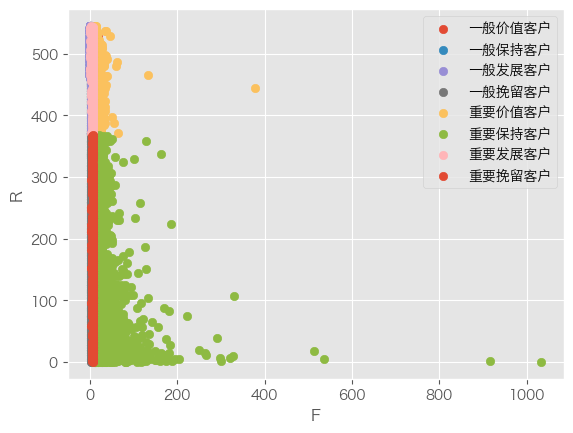

In [21]:
#客户分层可视化
for label,grouped in rfm.groupby(by='label'):
#     print(label,grouped)
    x = grouped['F']  # 单个用户的购买数量
    y = grouped['R']  #最近一次购买时间与98年7月的相差天数
    plt.scatter(x,y,label=label)
plt.legend()  #显示图例
plt.xlabel('F')
plt.ylabel('R')

## 新老，活跃，回流用户分析

- 新用户的定义是第一次消费。
- 活跃用户即老客，在某一个时间窗口内有过消费。
- 不活跃用户则是时间窗口内没有消费过的老客。
- 回流用户：相当于回头客的意思。
- 用户回流的动作可以分为自主回流与人工回流，自主回流指玩家自己回流了，而人工回流则是人为参与导致的。

In [22]:
pivoted_counts = df.pivot_table(
                index='user_id',
                columns ='month',
                values = 'order_dt',
                aggfunc = 'count'
).fillna(0)
pivoted_counts.head()

month,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# 由于浮点数不直观，并且需要转成是否消费过即可，用0、1表示
df_purchase = pivoted_counts.applymap(lambda x:1 if x>0 else 0)
# apply:作用与dataframe数据中的一行或者一列数据
# applymap:作用与dataframe数据中的每一个元素
# map:本身是一个series的函数，在df结构中无法使用map函数，map函数作用于series中每一个元素的
df_purchase.head()

month,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0


In [24]:
def active_status(data): #data：每一行数据（共18列）
    status = [] #存储用户18个月的状态（new|active|unactive|return|unreg）
    for i in range(18):
        #判断本月没有消费==0
        if data[i] ==0:
            if len(status)==0: #前几个月没有任何记录（也就是97年1月==0）
                status.append('unreg')  
            else:#之前的月份有记录（判断上一个月状态）
                if status[i-1] =='unreg':#一直没有消费过
                    status.append('unreg')
                else:#上个月的状态可能是：new|active|unative|reuturn
                    status.append('unactive')
        else:#本月有消费==1
            if len(status)==0:
                status.append('new') #第一次消费
            else:#之前的月份有记录（判断上一个月状态）
                if status[i-1]=='unactive':
                    status.append('return') #前几个月不活跃，现在又回来消费了，回流用户
                elif  status[i-1]=='unreg':
                    status.append('new') #第一次消费
                else:#new|active
                    status.append('active') #活跃用户
            
    return pd.Series(status,df_purchase.columns) #值：status,列名：18个月份

purchase_states = df_purchase.apply(active_status,axis=1) #得到用户分层结果
purchase_states.head()

month,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
2,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
3,new,unactive,return,active,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,return,unactive
4,new,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,unactive
5,new,active,unactive,return,active,active,active,unactive,return,unactive,unactive,return,active,unactive,unactive,unactive,unactive,unactive


In [25]:
#把unreg状态用nan替换
purchase_states_ct = purchase_states.replace('unreg',np.NaN).apply(lambda x:pd.value_counts(x))
purchase_states_ct.head()

month,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
active,NaN,1157.0,1681,1773.0,852.0,747.0,746.0,604.0,528.0,532.0,624.0,632.0,512.0,472.0,571.0,518.0,459.0,446.0
new,7846.0,8476.0,7248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
return,NaN,NaN,595,1049.0,1362.0,1592.0,1434.0,1168.0,1211.0,1307.0,1404.0,1232.0,1025.0,1079.0,1489.0,919.0,1029.0,1060.0
unactive,NaN,6689.0,14046,20748.0,21356.0,21231.0,21390.0,21798.0,21831.0,21731.0,21542.0,21706.0,22033.0,22019.0,21510.0,22133.0,22082.0,22064.0


<AxesSubplot:xlabel='month'>

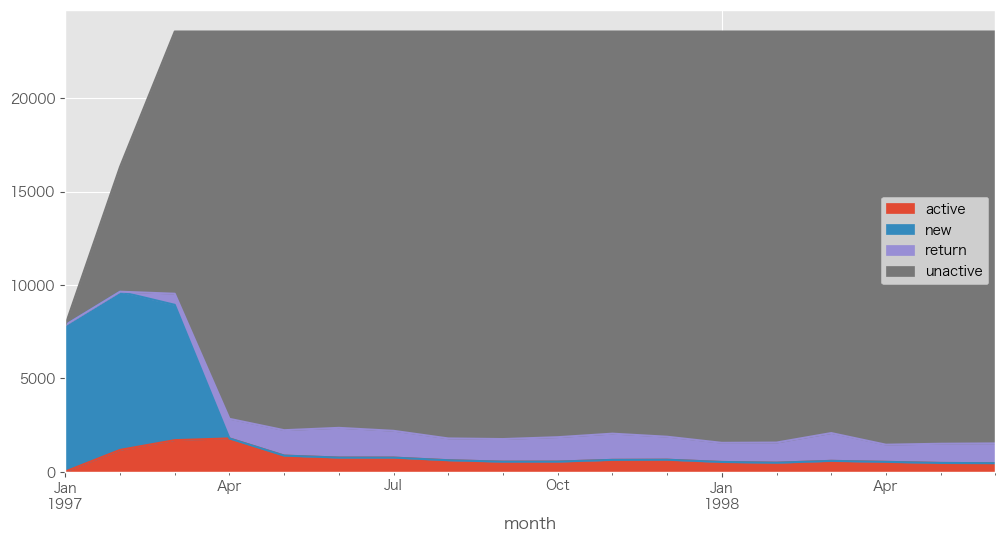

In [26]:
#数据可视化，面积图
purchase_states_ct.fillna(0).T.plot.area(figsize=(12,6))  #填充nan之后，进行行列变换
#由图可知：灰色区域是不活跃用户，占比较大
#前三个月新用户，还是活跃用户呈现了上升趋势，猜测由于活动造成的影响
#3月份过后，紫色回流用户，红色活跃用户，都呈现下降趋势，并且趋于平稳状态
#3月份过后，新用户量几乎没有大量增加

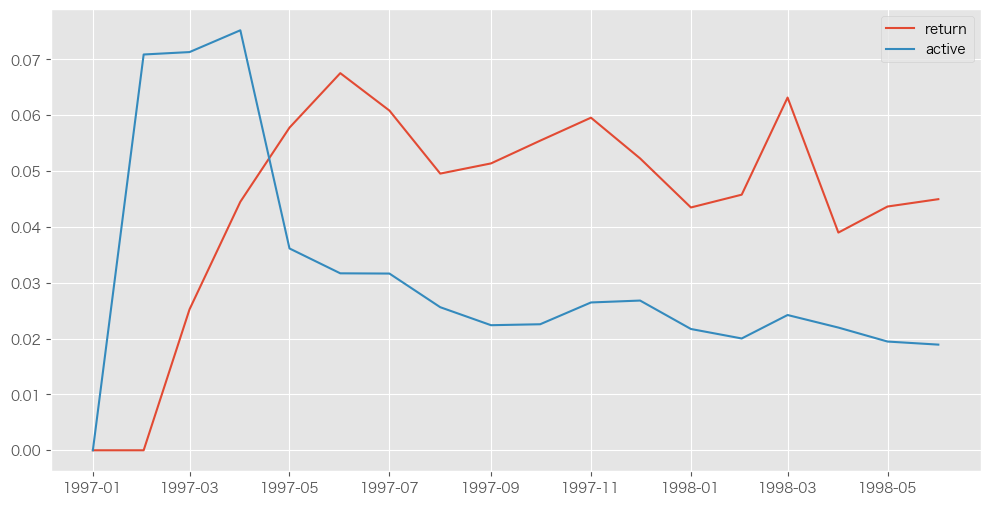

In [27]:
#每月中回流用户占比情况（占所有用户的比例）
plt.figure(figsize=(12,6))
rate = purchase_states_ct.fillna(0).T.apply(lambda x:x/x.sum(),axis=1)
plt.plot(rate['return'],label='return')
plt.plot(rate['active'],label='active')
plt.legend()
# 由图可知，前3个月，活跃用户占比比较大，维持在7%左右，而回流用户比例在上升，由于new用户还没有足够时间变成回流用户
# 4月份过后，不论是活跃用户，还是回流用户都呈现出下降趋势，但是回流用户依然高于活跃用户。

## 用户的购买周期

In [28]:
#shift函数：将数据移动到一定的位置 讲函数的没啥用
data1 = pd.DataFrame({
    'a':[0,1,2,3,4,5],
    'b':[5,4,3,2,1,0]
})
data1.shift(axis=0) #整体向下移动一个位置（默认值：axis=0）
data1.shift(axis=1)#整体朝右

,a,b
0,NaN,0
1,NaN,1
2,NaN,2
3,NaN,3
4,NaN,4
5,NaN,5


In [30]:
#计算购买周期（购买日期的时间差值）
order_diff = df.groupby(by='user_id').apply(lambda x:x['order_date']-x['order_date'].shift()) #当前订单日期-上一次订单日期 shift往下移了一个日期 减去的就是上一次购买日期了
order_diff.describe()

count                         46089
mean     68 days 23:22:13.567662566
std      91 days 00:47:33.924168893
min                 0 days 00:00:00
25%                10 days 00:00:00
50%                31 days 00:00:00
75%                89 days 00:00:00
max               533 days 00:00:00
Name: order_date, dtype: object

<AxesSubplot:>

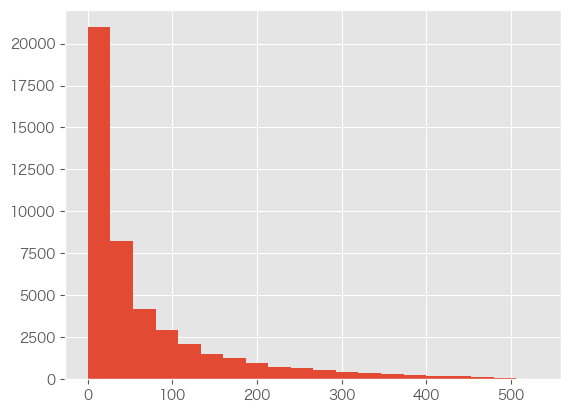

In [31]:
(order_diff/np.timedelta64(1,'D')).hist(bins = 20) #影响柱子的宽度，  每个柱子的宽度=（最大值-最小值）/bins
# 得知：平均消费周期为68天
# 大多数用户消费周期低于100天
# 呈现典型的长尾分布，只有小部分用户消费周期在200天以上（不积极消费的用户），可以在这批用户消费后3天左右进行电话回访后者短信
# 赠送优惠券等活动，增大消费频率

## 用户生命周期

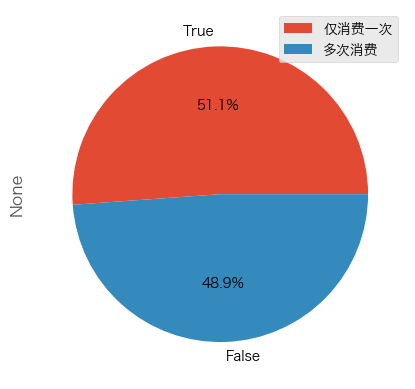

In [33]:
#计算方式：用户最后一次购买日期(max)-第一次购买的日期(min)。如果差值==0，说明用户仅仅购买了一次
user_life = df.groupby('user_id')['order_date'].agg(['min','max'])#agg同时求很多聚合函数
(user_life['max']==user_life['min']).value_counts().plot.pie(autopct='%1.1f%%') #格式化成1为小数
plt.legend(['仅消费一次','多次消费'])
#一半以上的用户仅仅消费了一次，说明运营不利，留存率不好

In [34]:
(user_life['max']-user_life['min']).describe()  #生命周期分析
#用户平均生命周期为134天，但是中位数==0，再次验证大多数用户消费了一次，低质量用户。
# 75%分位数以后的用户，生命周期>294天，属于核心用户，需要着重维持。
# 前三个月的新用户数据，所以分析的是这些用户的生命周期

count                          23570
mean     134 days 20:55:36.987696224
std      180 days 13:46:43.039788104
min                  0 days 00:00:00
25%                  0 days 00:00:00
50%                  0 days 00:00:00
75%                294 days 00:00:00
max                544 days 00:00:00
dtype: object

### 绘制所有用户生命周期直方图+多次消费

Text(0, 0.5, '用户人数')

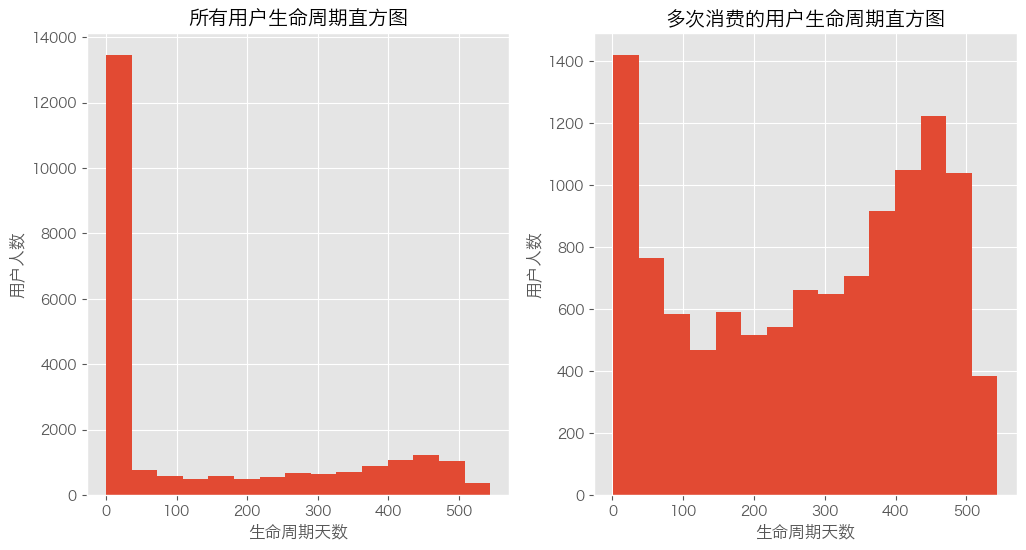

In [35]:
plt.figure(figsize=(12,6))
plt.subplot(121)
((user_life['max']-user_life['min'])/np.timedelta64(1,'D')).hist(bins=15)
plt.title('所有用户生命周期直方图')
plt.xlabel('生命周期天数')
plt.ylabel('用户人数')

plt.subplot(122)
u_1 = (user_life['max']-user_life['min']).reset_index()[0]/np.timedelta64(1,'D')
u_1[u_1>0].hist(bins=15)
plt.title('多次消费的用户生命周期直方图')
plt.xlabel('生命周期天数')
plt.ylabel('用户人数')
# 对比可知，第二幅图过滤掉了生命周期==0的用户，呈现双峰结构
# 虽然二图中还有一部分用户的生命周期趋于0天，但是比第一幅图好了很多，虽然进行了多次消费，但是不成长期
# 来消费，属于普通用户，可针对性进行营销推广活动
# 少部分用户生命周期集中在300~500天，属于我们的忠诚客户，需要大力度维护此类客户

## 复购率和回购率分析

### 复购率分析

<AxesSubplot:xlabel='month'>

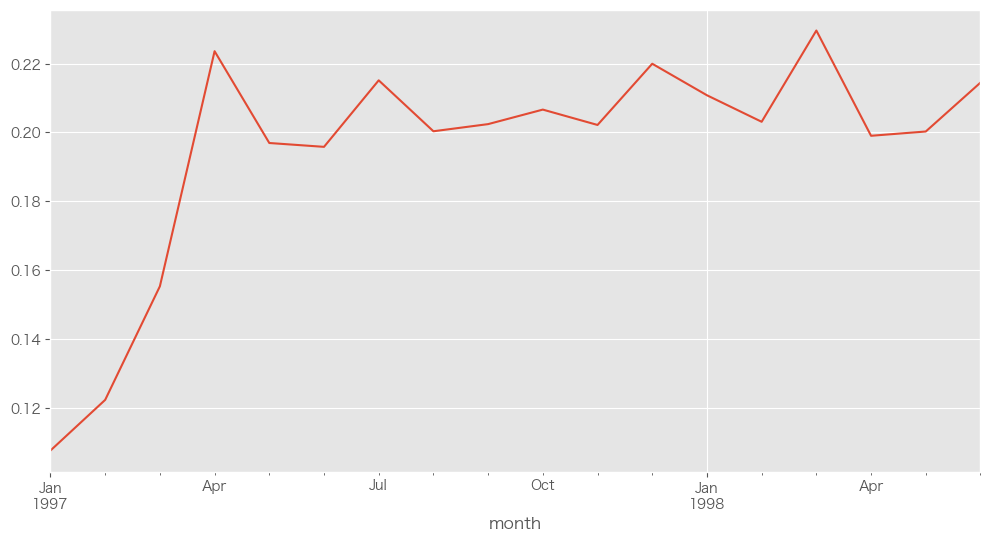

In [37]:
#计算方式：在自然月内，购买多次的用户在总消费人数中的占比（若客户在同一天消费了多次，也称之复购用户）
#消费者有三种：消费记录>=2次的；消费中人数；本月无消费用户；
#复购用户:1    非复购的消费用户：0   自然月没有消费记录的用户：NAN(不参与count计数)
purchase_r = pivoted_counts.applymap(lambda x: 1 if x>1 else np.NaN  if x==0  else 0)
purchase_r.head()
#purchase_r.sum() :求出复购用户
#purchase_r.count():求出所有参与购物的用户（NAN不参与计数）
(purchase_r.sum()/purchase_r.count()).plot(figsize=(12,6))
# 前三个月复购率开始上升，后续趋于平稳维持在20%~22%之间。
# 分析前三个月复购率低的原因，可能是因为大批新用户仅仅购买一次造成的。

### 回购率分析

In [39]:
#计算方式：在一个时间窗口内进行了消费，在下一个窗口内又进行了消费
def purchase_back(data):
    status = [] #存储用户回购率状态
    #1:回购用户   0：非回购用户（当前月消费了，下个未消费）   NaN:当前月份未消费
    for i in range(17):
        #当前月份消费了
        if data[i] == 1:
            if data[i+1]==1:
                status.append(1) #回购用户
            elif data[i+1] == 0: #下个月未消费
                status.append(0)
        else: #当前月份未进行消费
            status.append(np.NaN)
    status.append(np.NaN) #填充最后一列数据 一共18月
    return pd.Series(status,df_purchase.columns)

purchase_b = df_purchase.apply(purchase_back,axis=1)
purchase_b.head()

month,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


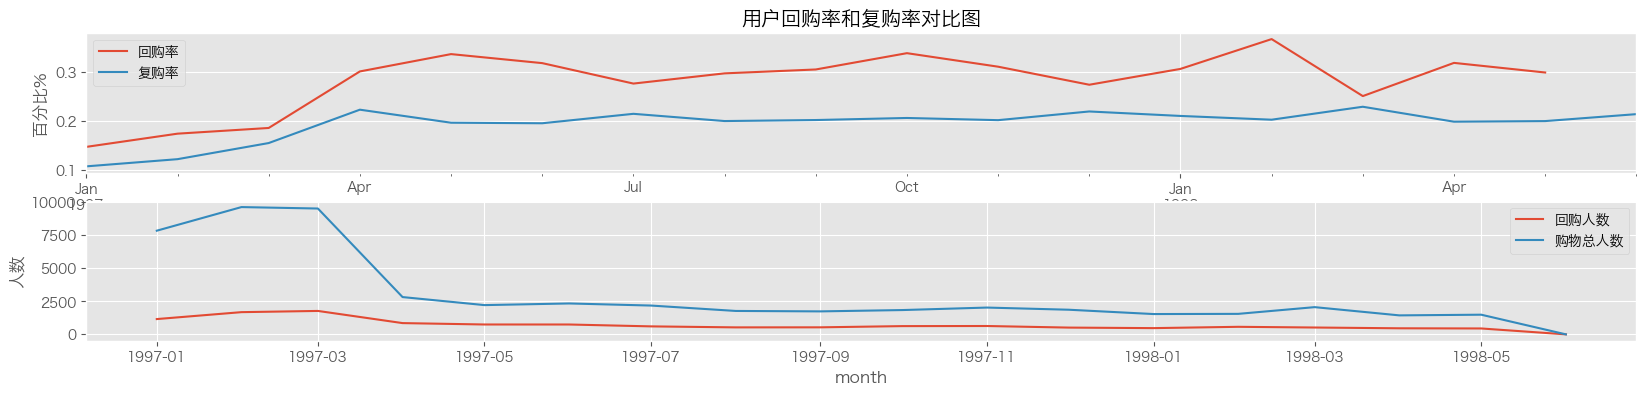

In [40]:
#回购率可视化
plt.figure(figsize=(20,4))
plt.subplot(211)
#回购率
(purchase_b.sum() / purchase_b.count()).plot(label='回购率')
#复购率
(purchase_r.sum()/purchase_r.count()).plot(label='复购率')
plt.legend()
plt.ylabel('百分比%')
plt.title('用户回购率和复购率对比图')
#回购率可知，平稳后在30%左右，波形性稍微较大
#复购率低于回购率，平稳后在20%左右，波动小较小
#前三个月不困是回购还是复购，都呈现上升趋势，说明新用户需要一定时间来变成复购或者回购用户
#结合新老用户分析，新客户忠诚度远低于老客户忠诚度。

#回购人数与购物总人数
plt.subplot(212)
plt.plot(purchase_b.sum(),label='回购人数')
plt.plot(purchase_b.count(),label='购物总人数')
plt.xlabel('month')
plt.ylabel('人数')
plt.legend()
# 前三个月购物总人数远远大于回购人数，主要是因为很多新用户在1月份进了首次购买
# 三个月后，回购人数和购物总数开始稳定，回购人数稳定在1000左右，购物总人数在2000左右。